### CP421 Project - Group 8 Recommendation Systems

In [1]:
# Yahya - Find pre-cleaned code in BCK3 file

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# read data
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

combine_movie_rating = pd.merge(ratings_df, movies_df, on='movieId')
columns = ['timestamp','genres']
combine_movie_rating = combine_movie_rating.drop(columns = columns, axis=1)


R_df = combine_movie_rating.pivot_table(index = 'userId', columns ='title', values = 'rating').fillna(0)

In [2]:
import math
R = R_df.values
R = np.array(R)

def train_test_split(ratings):

    validation = np.zeros(ratings.shape)
    train = ratings.copy()

    for user in np.arange(ratings.shape[0]):
        val = len(ratings[user,:].nonzero()[0])
        if val > 1:
            val *= 0.2
            if val < 1:
                val = math.ceil(val)
            else:
                val = round(val)
            val_ratings = np.random.choice(
              ratings[user, :].nonzero()[0],
              size=val,
              replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

t1,t2 = train_test_split(R)

new1 = pd.DataFrame(t1,columns = R_df.columns)
new2 = pd.DataFrame(t2,columns = R_df.columns)

In [3]:
print("Size of training Dataset:", np.count_nonzero(new2))
print("Size of testing Dataset:", np.count_nonzero(new1))

Size of training Dataset: 20164
Size of testing Dataset: 80668


In [4]:
R = new1.values
R = np.array(R)

numberUsers = len(R)
numberMovies = len(R[0])      

def test_rmse():
    rTest = R_df.values
    test = new2.values
    xs, ys = test.nonzero()
    predicted = reconstructR(gBias,biasUser,biasItem,P,Q)
    error = 0
    n = 0
    for x, y in zip(xs, ys):
        error += ((predicted[x,y] - rTest[x,y]) ** 2).mean()
        n+=1
    return np.sqrt(error/n)

def rmse():
    xArr, yArr = R.nonzero()
    predicted = reconstructR(gBias,biasUser,biasItem,P,Q)
    error = 0
    n = 0
    for x, y in zip(xArr, yArr):
        error += ((predicted[x,y] - R[x,y]) ** 2).mean()
        n+=1
    return np.sqrt(error/n)                              

def train():
        
    # Create a list of training samples
    training = [
        (i, j, R[i, j])
        for i in range(numberUsers)
        for j in range(numberMovies)
        if R[i, j] > 0
    ]
        
    # Perform stochastic gradient descent for number of iterations
    errorMin = []
    test_error_ar = []
    for i in range(iterations):
        np.random.shuffle(training)
        sgd(training,gBias,biasUser,biasItem,P,Q)
        e = rmse()
        errorMin.append((i, e))        
        t = test_rmse()
        test_error_ar.append((i,t))
    return errorMin, test_error_ar

def sgd(training, b, b_u,b_i,P,Q):
    for i, j, r in training:
        rHat = b + b_u[i] + b_i[j] + P[i, :].dot(Q[j, :].T)
        error = (r - rHat)
            

        b_u[i] += alpha * (error - beta * b_u[i])
        b_i[j] += alpha * (error - beta * b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
        temp = P[i, :][:]
            
            # Update user and item latent feature matrices
        P[i, :] += alpha * (error * Q[j, :] - beta * P[i,:])
        Q[j, :] += alpha * (error * temp - beta * Q[j,:])
            
#def predictR(i, j,b,b_u,b_i):
#    rHat = b + b_u[i] + b_i[j] + P[i, :].dot(Q[j, :].T)
#    return rHat

def reconstructR(b,b_u,b_i,P,Q):
    return b + b_u[:,np.newaxis] + b_i[np.newaxis:,] + P.dot(Q.T)

In [5]:
numberUsers = len(R)
numberMovies = len(R[0])      

def test_rmse_nobias():
    rTest = R_df.values
    test = new2.values
    xs, ys = test.nonzero()
    predicted = reconstructR_nobias(P,Q)
    error = 0
    n = 0
    for x, y in zip(xs, ys):
        error += ((predicted[x,y] - rTest[x,y]) ** 2).mean()
        n+=1
    return np.sqrt(error/n)

def rmse_nobias():
    xArr, yArr = R.nonzero()
    predicted = reconstructR_nobias(P,Q)
    error = 0
    n = 0
    for x, y in zip(xArr, yArr):
        error += ((predicted[x,y] - R[x,y]) ** 2).mean()
        n+=1
    return np.sqrt(error/n)                              

def train_nobias():
        
    # Create a list of training samples
    training = [
        (i, j, R[i, j])
        for i in range(numberUsers)
        for j in range(numberMovies)
        if R[i, j] > 0
    ]
        
    # Perform stochastic gradient descent for number of iterations
    errorMin = []
    test_error_arr = []
    for i in range(iterations):
        np.random.shuffle(training)
        sgd_nobias(training,P,Q)
        e = rmse_nobias()
        errorMin.append((i, e))        
        t = test_rmse_nobias()
        test_error_arr.append((i,t))
    return errorMin, test_error_arr

def sgd_nobias(training,P,Q):
    for i, j, r in training:
        rHat = P[i, :].dot(Q[j, :].T)
        error = (r - rHat)
            
            # Create copy of row of P since we need to update it but use older values for update on Q
        temp = P[i, :][:]
            
            # Update user and item latent feature matrices
        P[i, :] += alpha * (error * Q[j, :] - beta * P[i,:])
        Q[j, :] += alpha * (error * temp - beta * Q[j,:])

def reconstructR_nobias(P,Q):
    return P.dot(Q.T)

In [6]:
# Testing of alpha hyperparameters

# ------------Hyperparameters-----------
iterations = 8
alpha = 0.02      # learning rate
beta = 0.02                                  # regularization
K = 8                                        # latent features

# Initialize user and item latent feature matrice
P = np.random.normal(scale=1./K, size=(numberUsers, K))
Q = np.random.normal(scale=1./K, size=(numberMovies, K))
P = P.astype('float64')  
Q = Q.astype('float64')

## OUTPUT
error_arr,test_arr = train_nobias()
nr5 = pd.DataFrame(reconstructR_nobias(P,Q),columns = R_df.columns)
print("\n" * 2)
print(iterations,"iterations")
print("α =", alpha)
print("β =", beta)
print("k =", K)
print()
print(error_arr)
print(test_arr)
# nr5.head(10)




8 iterations
α = 0.02
β = 0.02
k = 8

[(0, 1.7244593291686983), (1, 1.1348372110537763), (2, 0.9604336181316931), (3, 0.8743321581695416), (4, 0.8171705496179914), (5, 0.7819700027237735), (6, 0.7562898504008545), (7, 0.7324144834778933)]
[(0, 1.826515084145791), (1, 1.331804781395532), (2, 1.2178457950404602), (3, 1.1747256469919916), (4, 1.1499676575890474), (5, 1.1400225531315864), (6, 1.1341794570510717), (7, 1.129743498298777)]


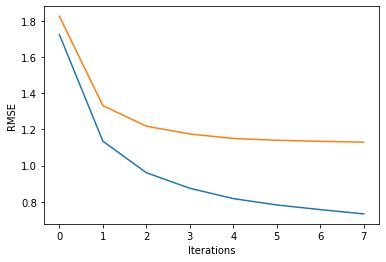

In [7]:
import matplotlib.pyplot as plt
data = np.array(error_arr)
other_data = np.array(test_arr)
x, y = data.T
plt.plot(x,y)
x,y = other_data.T
plt.plot(x,y)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.show()

In [8]:
# Testing of alpha hyperparameters

# ------------Hyperparameters-----------
iterations = 8
alpha = 0.02      # learning rate
beta = 0.02                                  # regularization
K = 8                                        # latent features

# Initialize user and item latent feature matrice
P = np.random.normal(scale=1./K, size=(numberUsers, K))
Q = np.random.normal(scale=1./K, size=(numberMovies, K))
P = P.astype('float64')  
Q = Q.astype('float64')

# Initialize the biases
biasUser = np.zeros(numberUsers)           
biasItem = np.zeros(numberMovies)       
gBias = np.mean(R[np.where(R != 0)])

## OUTPUT
error_arr,test_error = train()
nr5 = pd.DataFrame(reconstructR(gBias,biasUser,biasItem,P,Q),columns = R_df.columns)
print("\n" * 2)
print(iterations,"iterations")
print("α =", alpha)
print("β =", beta)
print("k =", K)
print()
print(error_arr)
print(test_error)




8 iterations
α = 0.02
β = 0.02
k = 8

[(0, 0.8729286053563371), (1, 0.8470492295192091), (2, 0.8316050365118628), (3, 0.8158273727072127), (4, 0.7994866306132187), (5, 0.7811230607792318), (6, 0.759528226943515), (7, 0.7376082533326603)]
[(0, 0.9024462123235246), (1, 0.8889394553938663), (2, 0.8844180885763476), (3, 0.8799424565102679), (4, 0.8772633096793502), (5, 0.8756451974218682), (6, 0.8753429316499752), (7, 0.8739773356559571)]


In [9]:
rTest = R_df.values
test = new2.values
xs, ys = test.nonzero()
predicted = reconstructR(gBias,biasUser,biasItem,P,Q)
error = 0
n = 0
for x, y in zip(xs, ys):
    error += ((predicted[x,y] - rTest[x,y]) ** 2).mean()
    n+=1
print(np.sqrt(error/n))            

0.8739773356559571


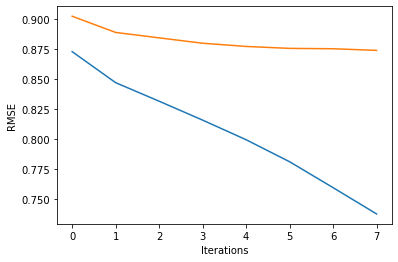

In [10]:
import matplotlib.pyplot as plt
data = np.array(error_arr)
x, y = data.T
plt.plot(x,y)
other_data = np.array(test_error)
x, y = other_data.T
plt.plot(x,y)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.show()

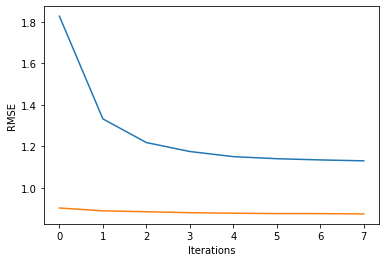

In [12]:
data = np.array(test_arr)
x, y = data.T
plt.plot(x,y)
other_data = np.array(test_error)
x, y = other_data.T
plt.plot(x,y)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.show()

In [11]:
# Testing of alpha hyperparameters
print("Tuning of iterations")

for i in range(6):
    
    # ------------Hyperparameters-----------

    iterations = 25
    alpha = round(0.01 + (0 if i == 0 else (i/100)), 2)      # learning rate
    beta = 0.02                                  # regularization
    K = 6                                        # latent features

    # Initialize user and item latent feature matrice
    P = np.random.normal(scale=1./K, size=(numberUsers, K))
    Q = np.random.normal(scale=1./K, size=(numberMovies, K))
    P = P.astype('float64')  
    Q = Q.astype('float64')

    # Initialize the biases
    biasUser = np.zeros(numberUsers)           
    biasItem = np.zeros(numberMovies)       
    gBias = np.mean(R[np.where(R != 0)])

    ## OUTPUT
    error_arr = train()
    nr5 = pd.DataFrame(reconstructR(gBias,biasUser,biasItem,P,Q),columns = R_df.columns)
    print("\n" * 2)
    print(iterations,"iterations")
    print("α =", alpha)
    print("β =", beta)
    print("k =", K)
    print()
    print(error_arr)
    alpha = round(alpha - 0.01, 2)
    # nr5.head(10)

Tuning of iterations



25 iterations
α = 0.01
β = 0.02
k = 6

([(0, 0.8977273386339502), (1, 0.8716805927654336), (2, 0.8564442837164112), (3, 0.8455049724833811), (4, 0.8368074902635397), (5, 0.829411984002748), (6, 0.8225750852154378), (7, 0.815436109679735), (8, 0.8088814480252672), (9, 0.8022320118551158), (10, 0.7950578034697923), (11, 0.7877524973883445), (12, 0.7800660041455498), (13, 0.7721679573745782), (14, 0.7643715967036927), (15, 0.7562072385067871), (16, 0.7479850879527545), (17, 0.7401589503019638), (18, 0.7323991143817923), (19, 0.725008670376227), (20, 0.7181452660111399), (21, 0.7108830988313175), (22, 0.7046549114753875), (23, 0.6979264677794663), (24, 0.6920450049302175)], [(0, 0.9186107021248171), (1, 0.9022645483315637), (2, 0.8944635515586506), (3, 0.8896745585218232), (4, 0.8870510640920436), (5, 0.8848076529886327), (6, 0.8835028556563168), (7, 0.8821177724481707), (8, 0.8821630861209596), (9, 0.8816918383598433), (10, 0.8812803648866728), (11, 0.8823196842042